# Continual learning sparse Gaussian processes 

We consider a different artificial data set than Bui et al. (2018).

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
import logging
import copy

module_path = os.path.abspath(os.path.join("../../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from pvi.models.sgp.sgp import *
from pvi.models.sgp.kernels import *
from pvi.distributions import MultivariateGaussianDistributionWithZ, MultivariateGaussianFactorWithZ
from pvi.distributions import GammaDistribution, GammaFactor, LogNormalDistribution, LogNormalFactor
from pvi.distributions.hypers import HyperparameterDistribution, HyperparameterFactor
from pvi.clients import ContinualLearningSGPClient, ContinualLearningSGPClientBayesianHypers
from pvi.servers import ContinualLearningServer, ContinualLearningServerBayesianHypers


import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm
from sklearn import datasets
import gpytorch

from torch import nn
from pvi.models.sgp.kernels import RBFKernel


%matplotlib inline
torch.set_default_dtype(torch.float64)

### Set up data and helper functions

In [4]:
def load_data(name, train_proportion, data_base_dir):
    filename = os.path.join(data_base_dir, name, "banana.csv")
    data = np.loadtxt(filename, delimiter=",", skiprows=1)
    print(len(data))
    x = data[:, :2]
    y = data[:, -1]
    
    
    # Replace 1's with 0's and -1's with 1's.
    y[y == 1] = 0
    y[y == -1] = 1
    
    N = x.shape[0]
    N_train = int(np.ceil(train_proportion * N))
    
    x_train = x[0:N_train]
    y_train = y[0:N_train]
    x_test = x[N_train:]
    y_test = y[N_train:]
    
    print("Training Length: ", len(y_train), " || Testing Length: ", len(y_test))

    training_set = {
        "x": x_train,
        "y": y_train,
    }

    test_set = {
        "x": x_test,
        "y": y_test
    }

    D = x_test.shape[1]

    return training_set, test_set, D

def generate_clients_data(x, y, M, dataset_seed):
        # this function ought to return a list of (x, y) tuples.
        # you need to set the seed in the main experiment file to ensure that this function becomes deterministic

        random_state = np.random.get_state()

        if dataset_seed is not None:
            np.random.seed(dataset_seed)

        if M == 1:
            client_data = [{"x": x, "y": y}]
            N_is = [x.shape[0]]
            props_positive = [np.mean(y > 0)]

            return client_data, N_is, props_positive, M

        N = x.shape[0]
        client_size = int(np.floor(N/M))

        class_balance = np.mean(y == 0)

        pos_inds = np.where(y > 0)
        zero_inds = np.where(y == 0)
        
        assert (len(pos_inds[0]) + len(zero_inds[0])) == len(y), "Some indeces missed."
        
        print(f'x shape {x.shape}')
#         print(f'positive indices {pos_inds}')
#         print(f'zero indices {zero_inds}')

        y_pos = y[pos_inds]
        y_neg = y[zero_inds]

        x_pos = x[pos_inds]
        x_neg = x[zero_inds]

        client_data = []

        # Recombine remaining data and shuffle.
        x = np.concatenate([x_pos, x_neg])
        y = np.concatenate([y_pos, y_neg])
        
        # As in Bui et al, order according to x1 value.
        inds = np.argsort(x[:, 0])

        x = x[inds]
        y = y[inds]

        # Distribute among large clients.
        for i in range(M):
            client_x = x[:client_size]
            client_y = y[:client_size]

            x = x[client_size:]
            y = y[client_size:]

            client_data.append({'x': client_x, 'y': np.float64(client_y)})

        N_is = [data['x'].shape[0] for data in client_data]
        props_positive = [np.mean(data['y'] > 0) for data in client_data]

        np.random.set_state(random_state)

        print(f'N_is {N_is}')
        print(f'Props positive: {props_positive}')

        return client_data, N_is, props_positive, M

In [12]:
# Definitions of the different types of plots
def plot_data(x, y, ax=None):
    x1_min, x1_max = -1.5, 2.5
    x2_min, x2_max = -1., 1.5
    
    x1x1, x2x2 = np.meshgrid(np.linspace(x1_min, x1_max, 100), 
                             np.linspace(x2_min, x2_max, 100))
    
    if ax is None:
        plt.figure(figsize=(8, 6), dpi=200)
        plt.xlim(x1x1.min(), x1x1.max())
        plt.ylim(x2x2.min(), x2x2.max())
        ax = plt.gca()
    
    ax.plot(x[y == 0, 0], x[y == 0, 1], "o", color="C1", label="Class 1", alpha=.5)
    ax.plot(x[y == 1, 0], x[y == 1, 1], "o", color="C0", label="Class 2", alpha=.5)
    
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend(loc="upper left", scatterpoints=1, numpoints=1)
    
    return x1x1, x2x2

def plot_predictive_distribution(x, y, z, model, q, ax=None, x_old=None, y_old=None, z_old=None):
    x1x1, x2x2 = plot_data(x, y, ax)
    
    if ax is None:
        ax = plt.gca()
    
    x_predict = np.concatenate((x1x1.ravel().reshape(-1, 1), 
                                x2x2.ravel().reshape(-1, 1)), 1)
    
    y_predict = model(torch.tensor(x_predict), q=q, diag=True)
    y_predict = y_predict.mean.detach().numpy().reshape(x1x1.shape)
    
    cs2 = ax.contour(x1x1, x2x2, y_predict, colors=["k"],  levels=[0.2, 0.5, 0.8])#linewidth=2,
    ax.clabel(cs2, fmt="%2.1f", colors="k", fontsize=14)
        
    ax.scatter(z[:, 0], z[:, 1], color="r", marker="s")
    
    if x_old is not None:
        ax.plot(x_old[y_old == 0, 0], x_old[y_old == 0, 1], "o", color="C1", label="Class 1", alpha=.1)
        ax.plot(x_old[y_old == 1, 0], x_old[y_old == 1, 1], "o", color="C0", label="Class 2", alpha=.1)
        ax.scatter(z_old[:, 0], z_old[:, 1], color="r", marker="o")        
        
def plot_bayesian_predictive_distribution(x, y, z, model, q, qeps, ax=None, x_old=None, y_old=None, z_old=None, neps=10):
    x1x1, x2x2 = plot_data(x, y, ax)
    
    if ax is None:
        ax = plt.gca()
    
    x_predict = np.concatenate((x1x1.ravel().reshape(-1, 1), 
                                x2x2.ravel().reshape(-1, 1)), 1)
    
    preds = []
    for _ in range(neps):
        eps = qeps.sample()
        model.hyperparameters = eps
        pp = model(torch.tensor(x_predict), q, diag=True)
        preds.append(pp.mean.detach().numpy())
        
    y_predict = (sum(preds) / len(preds)).reshape(x1x1.shape)
    
    cs2 = ax.contour(x1x1, x2x2, y_predict, colors=["k"], levels=[0.2, 0.5, 0.8])
    ax.clabel(cs2, fmt="%2.1f", colors="k", fontsize=14)
        
    ax.scatter(z[:, 0], z[:, 1], color="r", marker="s")
    
    if x_old is not None:
        ax.plot(x_old[y_old == 0, 0], x_old[y_old == 0, 1], "o", color="C1", label="Class 1", alpha=.1)
        ax.plot(x_old[y_old == 1, 0], x_old[y_old == 1, 1], "o", color="C0", label="Class 2", alpha=.1)
        ax.scatter(z_old[:, 0], z_old[:, 1], color="r", marker="o")
    

In [13]:
num_samples = 2100
noise = .1
seed = 42
data = datasets.make_moons(n_samples=num_samples, noise=noise, random_state=seed)
training_set = {
    "x": data[0],
    "y": data[1],
}

In [14]:
test_samples= int(num_samples / 0.8 - num_samples)
seed = 37
data_test = datasets.make_moons(n_samples=test_samples, noise=noise, random_state=seed)
test_set = {
    "x": data_test[0],
    "y": data_test[1],
}

In [15]:
print(test_set["x"][0][0].dtype)

float64


In [16]:
print(training_set["y"].dtype)

int64


In [24]:
M = 4
D=2
clients_data, nis, prop_positive, M = generate_clients_data(
    training_set["x"], 
    training_set["y"], 
    #Should be an error in creating y since x can be plotted in a coordinate system and are two dim 
    M=M,
    dataset_seed=0,
)

x shape (2100, 2)
N_is [525, 525, 525, 525]
Props positive: [0.0380952380952381, 0.6342857142857142, 0.38666666666666666, 0.940952380952381]


In [25]:
clients_data[0]["y"].dtype

dtype('float64')

## Plotting the Data

#### Complete Data set:

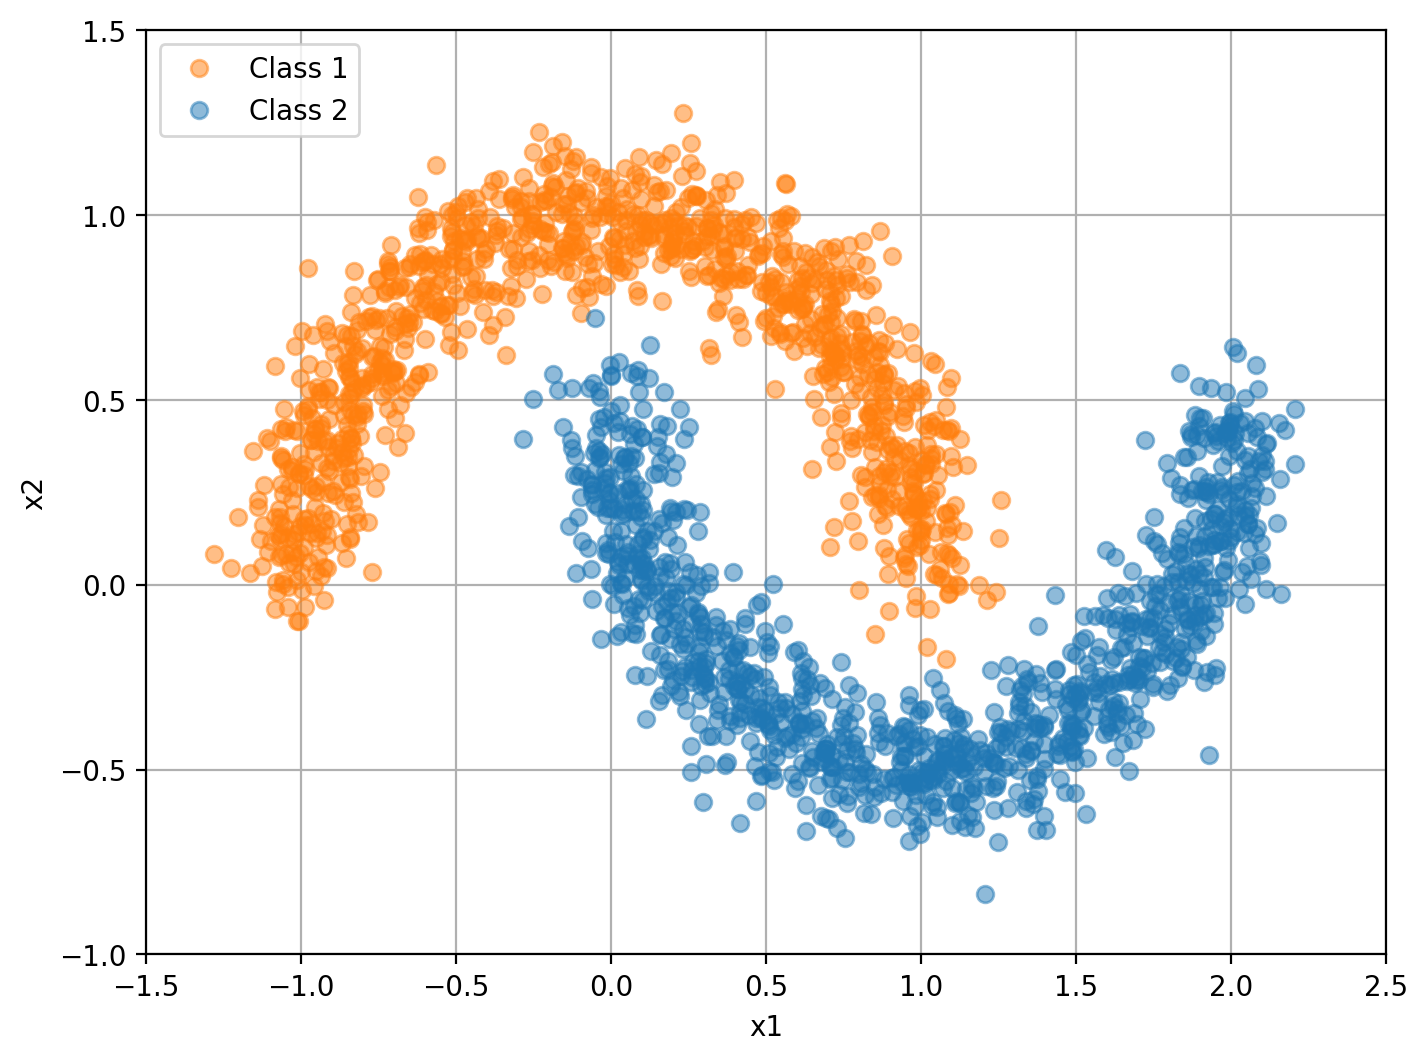

In [26]:
plot_data(training_set["x"], training_set["y"])
plt.grid(visible=True)
plt.show()

#### Shard #1:

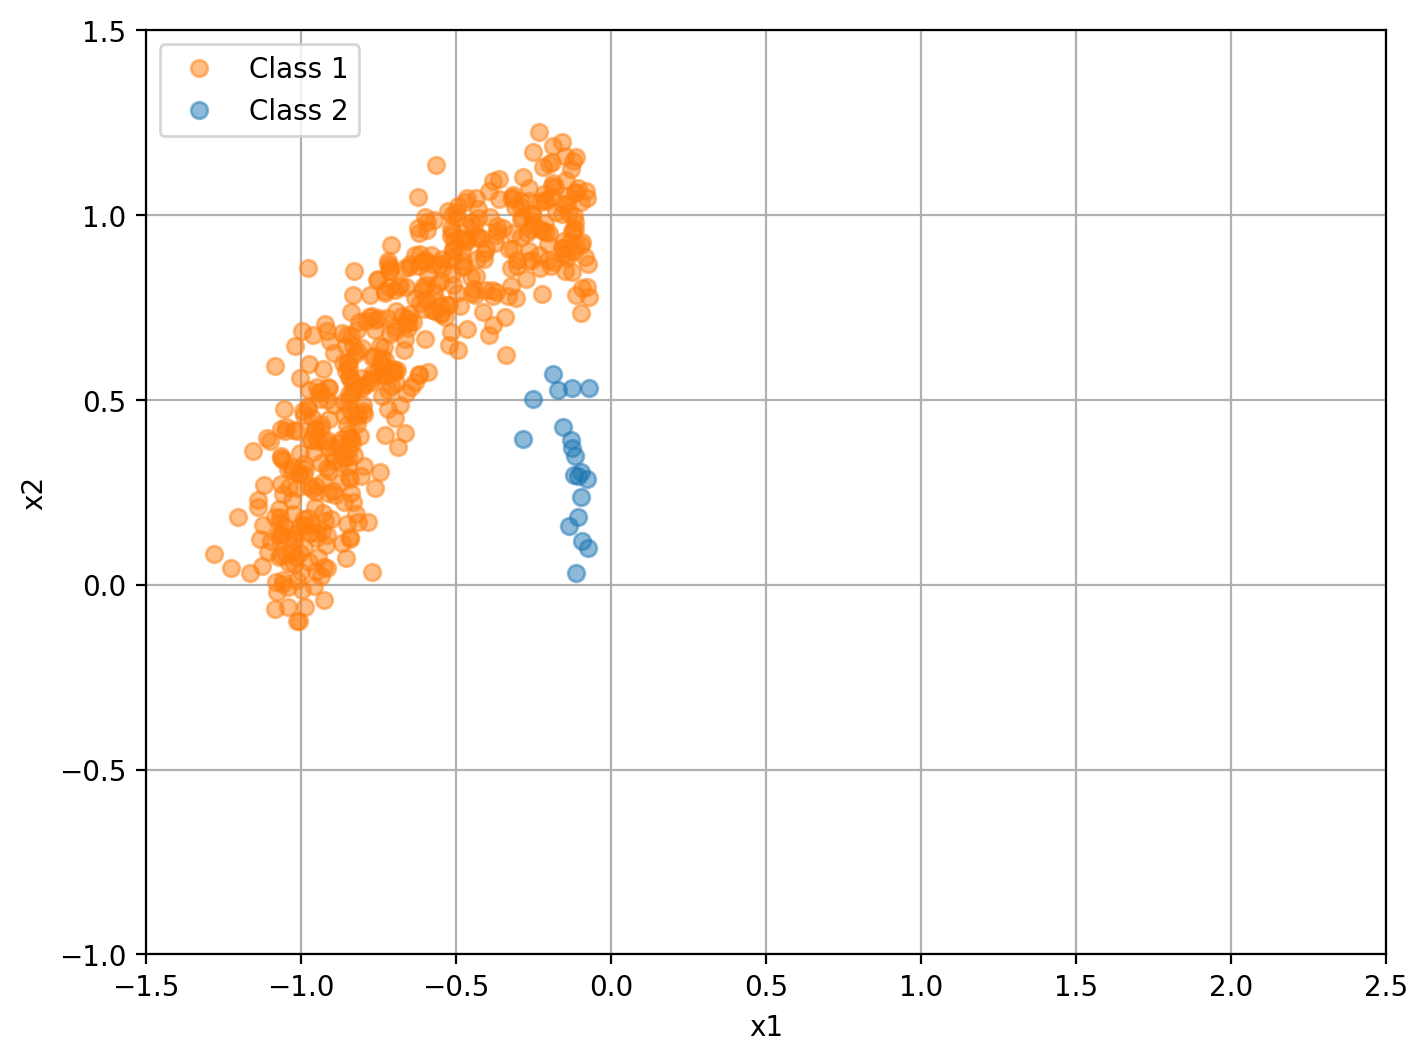

In [27]:
plot_data(clients_data[0]["x"], clients_data[0]["y"])
plt.grid(visible=True)
plt.show()

#### Shard #2:

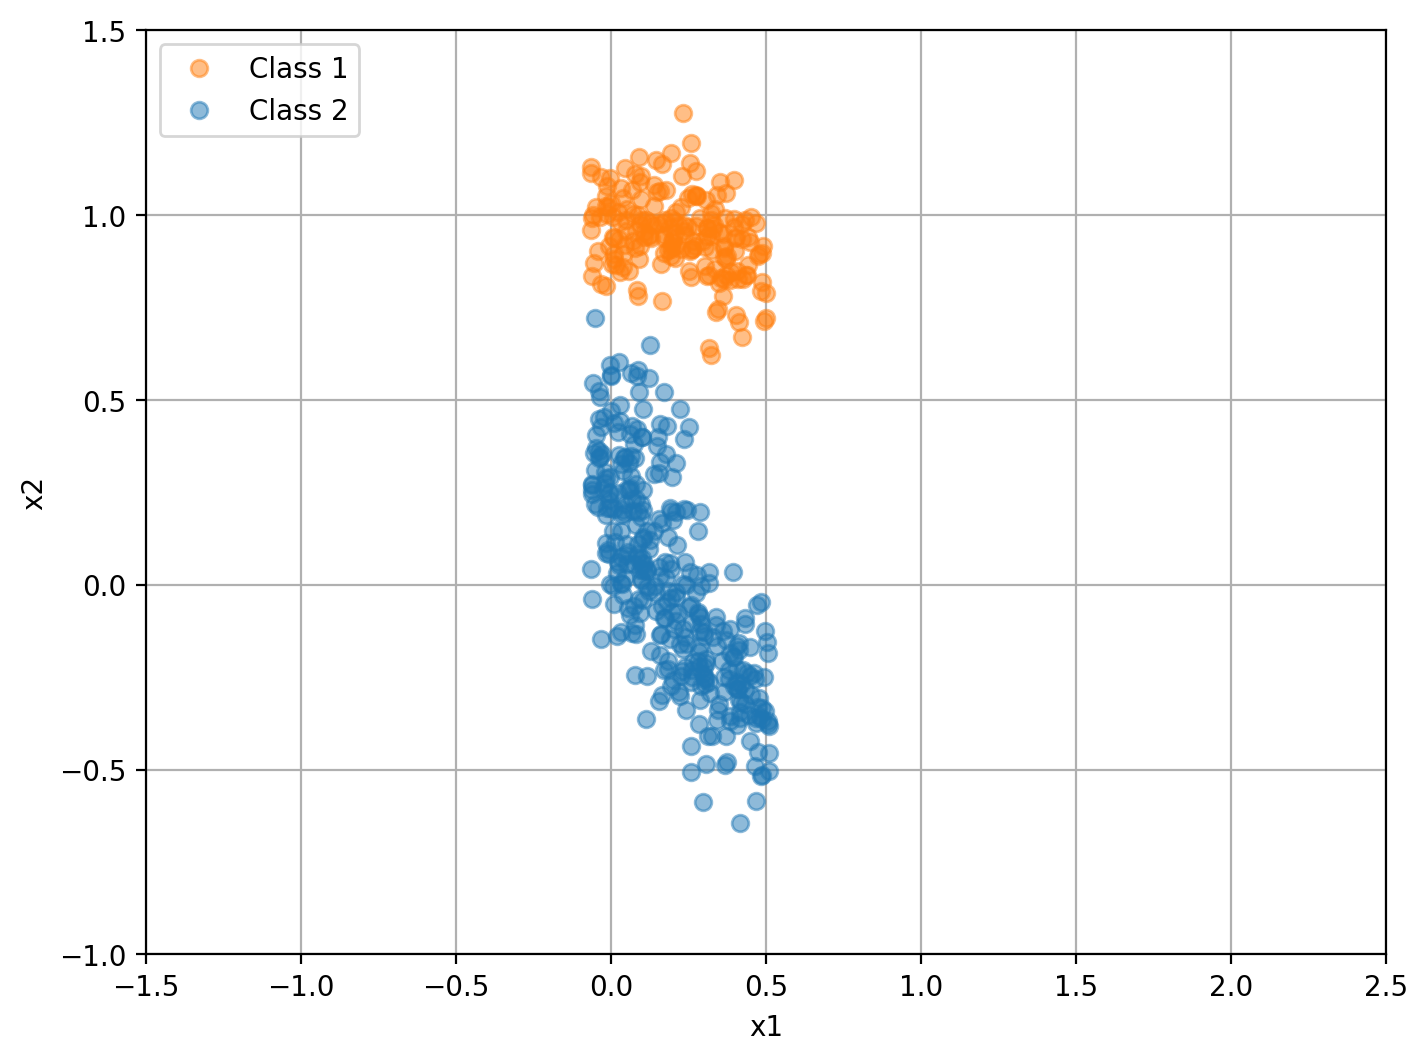

In [28]:
plot_data(clients_data[1]["x"], clients_data[1]["y"])
plt.grid(visible=True)
plt.show()

#### Shard #3:

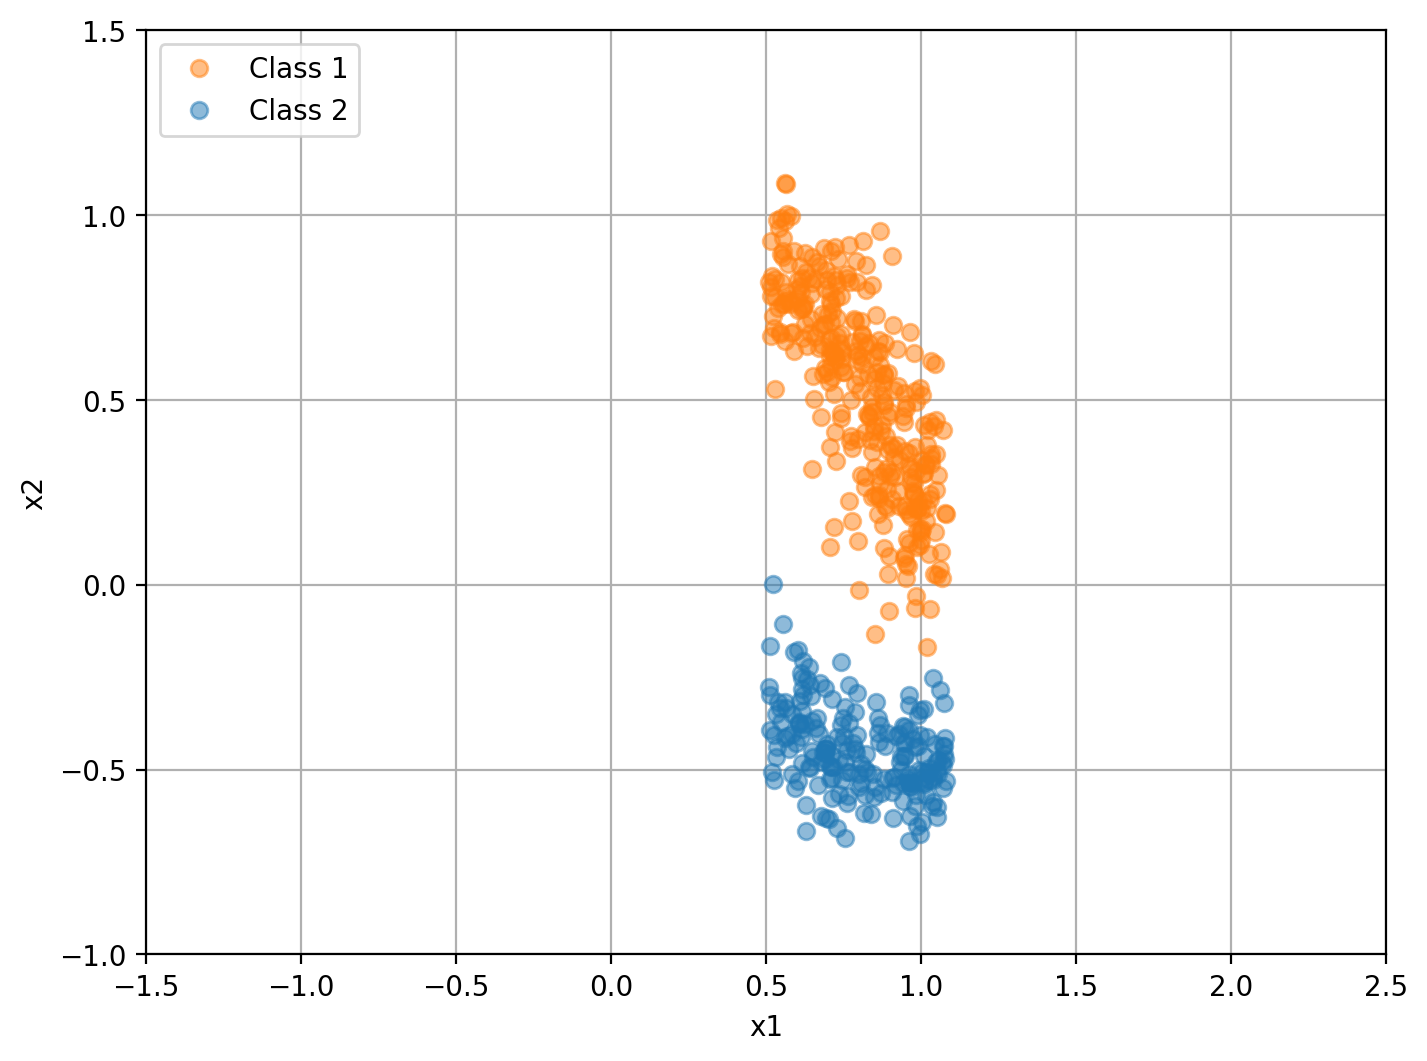

In [29]:
plot_data(clients_data[2]["x"], clients_data[2]["y"])
plt.grid(visible=True)
plt.show()

#### Shard #4:

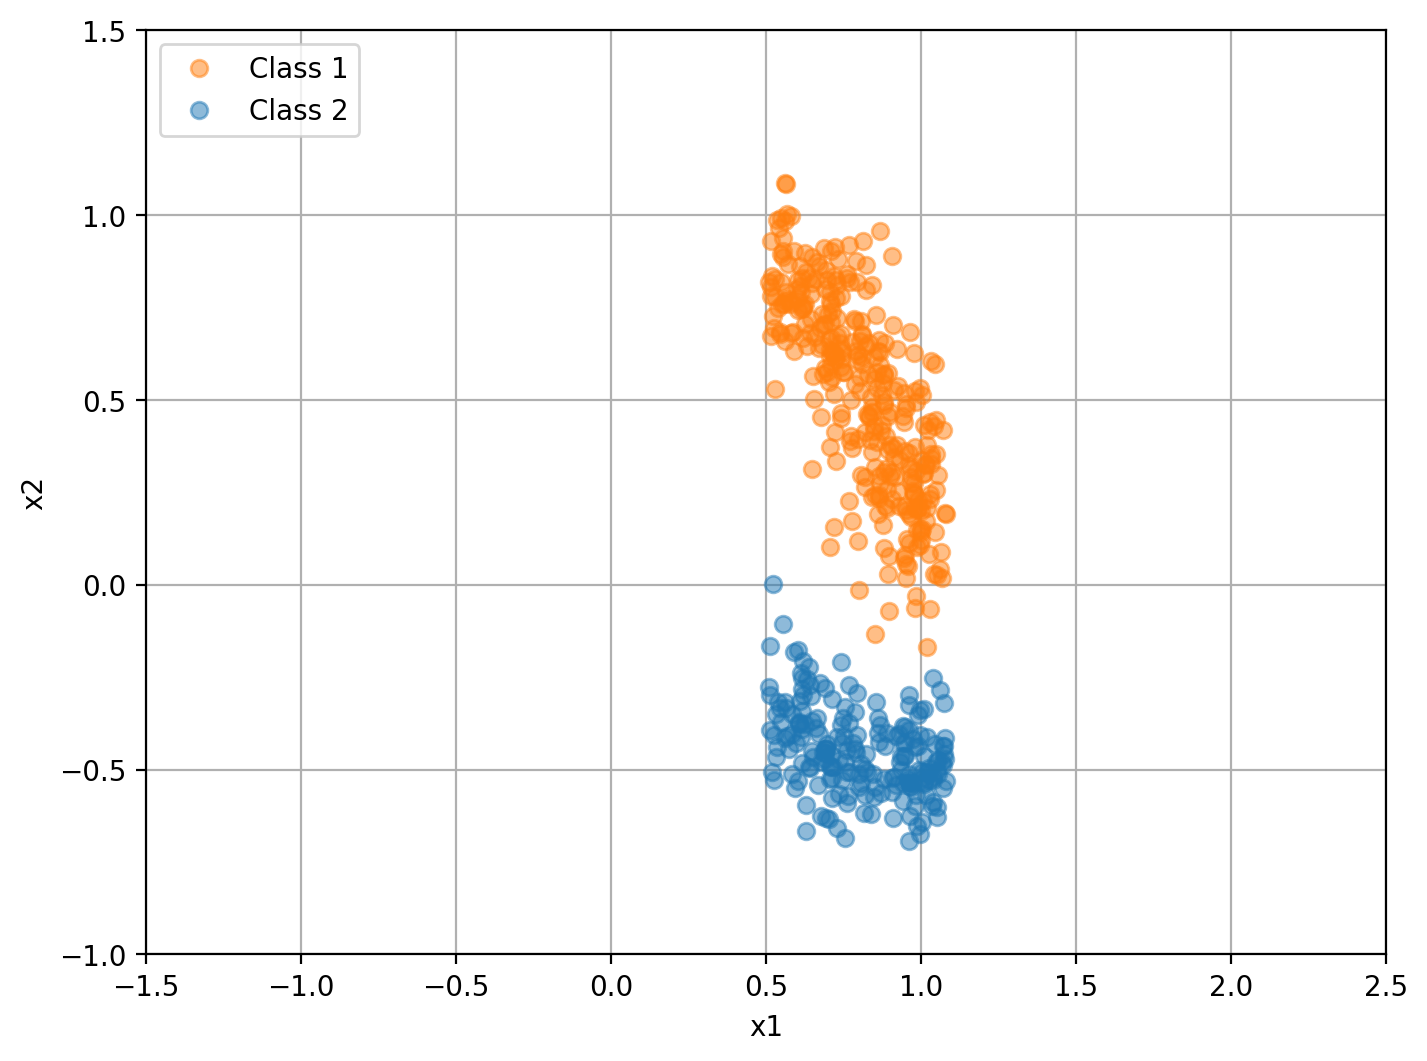

In [30]:
plot_data(clients_data[2]["x"], clients_data[2]["y"])
plt.grid(visible=True)
plt.show()

#### Test data:

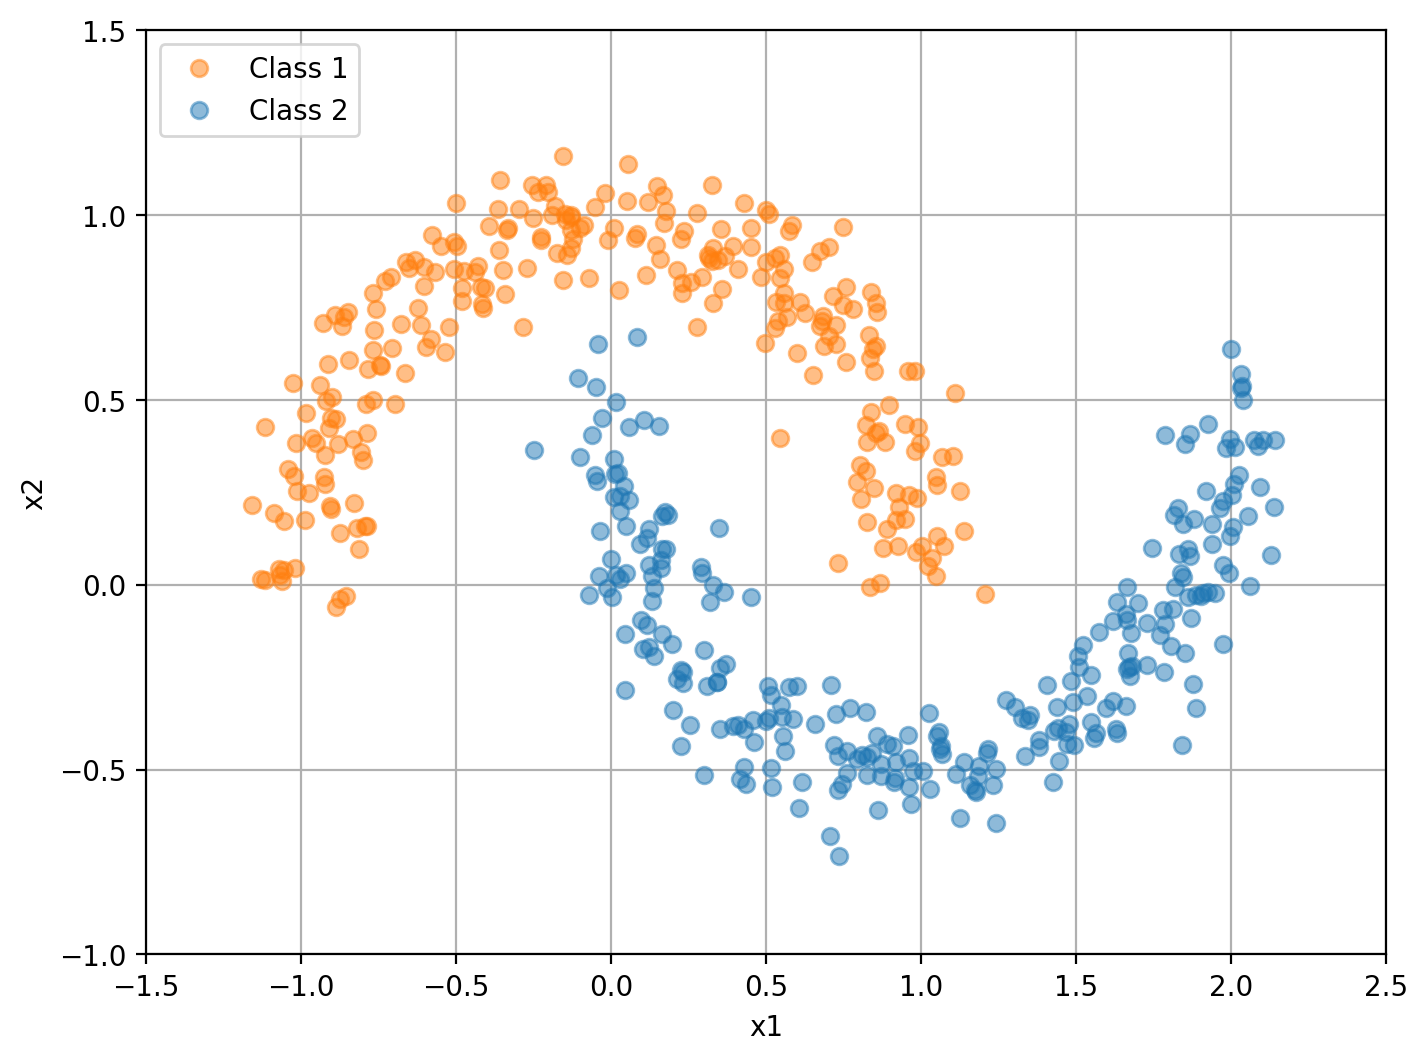

In [31]:
plot_data(test_set["x"], test_set["y"])
plt.grid(visible=True)
plt.show()

# ML training of hyperparameters

Hyperparameters are optimised by maximising the ELBO at each dataset, defined by

$$
\mathcal{F}(q_{\text{new}}(f), \theta_{\text{new}}) = \mathrm{KL}\left(q(\mathbf{b}, \mathbf{a}) \| p\left(\mathbf{b}, \mathbf{a} | \theta_{\mathrm{new}}\right)\right)-\int \mathrm{d} f q_{\mathrm{new}}(f) \log p\left(\mathbf{y}_{\text {new }} | f\right) - \int \mathrm{d}\mathbf{a} q(\mathbf{a}) \log \frac{q(\mathbf{a})}{p\left(\mathbf{a} | \theta_{\mathrm{old}}\right)}.
$$

where $$q_{old}(f) = p(f_{\setminus \mathbf{a}} | \mathbf{a})q(\mathbf{a})$$ is the old approximate posterior and $$q_{new}(f) = p(f_{\setminus \mathbf{a}\mathbf{b}} | \mathbf{a}, \mathbf{b}, \theta_{new})q(\mathbf{a})q(\mathbf{b} | \mathbf{a})$$ is the new approximate posterior.

In [41]:
num_inducing = 5

server_config = {
    "max_iterations": M,
    "train_model": True,
    "model_optimiser_params": {"lr": 5e-2},
    "num_eps_samples": 10,
}

init_nat_params = {
    "np1": torch.zeros(num_inducing),
    "np2": torch.zeros(num_inducing).diag_embed(),
}

In [42]:
model_config = {
    "D": D,
    "num_inducing": num_inducing,
    "kernel_class": lambda **kwargs: RBFKernel(**kwargs),
    "kernel_params": {
        "ard_num_dims": D, 
        "train_hypers": True
    },
    "num_predictive_samples": 100
}

model_hyperparameters = {
    "outputscale": 2.,
    "lengthscale": torch.ones(D) * 1.
}

client_config = {
    "optimiser": "Adam",
    "optimiser_params": {"lr": 1e-2},
    "epochs": 1000,
    "batch_size": len(clients_data[0]["x"]),
    "num_elbo_samples": 100,
    "num_elbo_hyper_samples": 2,
    "num_predictive_samples": 100,
    "train_model": True,
}

ml_clients = []
# Construct clients.
for i in range(M):
    model_i = SparseGaussianProcessClassification(config=model_config, hyperparameters=model_hyperparameters)
    data_i = clients_data[i]
    
    # Convert to torch.tensor.
    for k, v in data_i.items():
        data_i[k] = torch.tensor(v)
        #data_i[k] = v.clone().detach()
    
    # Randomly initialise private inducing points.
    perm = torch.randperm(len(data_i["x"]))
    idx = perm[:model_config["num_inducing"]]
    #Prev: z_i = torch.tensor(data_i["x"][idx]).clone()
    z_i = data_i["x"][idx].clone().detach()
    
    ml_clients.append(ContinualLearningSGPClient(
        data=data_i, model=model_i, inducing_locations=z_i, config=client_config))

# Construct global model and server.
model = SparseGaussianProcessClassification(config=model_config, hyperparameters=model_hyperparameters)

q = MultivariateGaussianDistributionWithZ(
    inducing_locations=None,
    #prev None
    nat_params=init_nat_params, 
    is_trainable=False
)

ml_server = ContinualLearningServer(
    model=model, 
    p=q, 
    clients=ml_clients,
    config=server_config
)

{'ard_num_dims': 2, 'train_hypers': True}
{'ard_num_dims': 2, 'train_hypers': True}
{'ard_num_dims': 2, 'train_hypers': True}
{'ard_num_dims': 2, 'train_hypers': True}
{'ard_num_dims': 2, 'train_hypers': True}


/var/folders/6x/7wzwn4g54n38_8rfbfx611n00000gn/T/ipykernel_77457/961763682.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_i[k] = torch.tensor(v)


In [43]:
while not ml_server.should_stop():
    ml_server.tick()

    # Obtain predictions.
    pp = ml_server.model_predict(torch.tensor(test_set["x"]), diag=True)
    preds = pp.mean.detach().numpy()
    test_acc = np.sum(
        np.abs(2 * (preds > 0.5) - 1 + test_set["y"]) > 0) / np.size(test_set["y"])

    print(test_acc)

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Updated model hyperparameters.
New model hyperparameters:
{'kernel.log_outputscale': tensor(7.2731), 'kernel.log_lengthscale': tensor([[0.0861, 0.1027]])}
.
1.0


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Updated model hyperparameters.
New model hyperparameters:
{'kernel.log_outputscale': tensor(0.4335), 'kernel.log_lengthscale': tensor([[-2.9715, -2.1713]])}
.
0.7352380952380952


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Updated model hyperparameters.
New model hyperparameters:
{'kernel.log_outputscale': tensor(2.4460), 'kernel.log_lengthscale': tensor([[-1.2360, -1.0955]])}
.
0.8228571428571428


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Updated model hyperparameters.
New model hyperparameters:
{'kernel.log_outputscale': tensor(-0.0499), 'kernel.log_lengthscale': tensor([[-0.3711, -4.1051]])}
.
0.7085714285714285


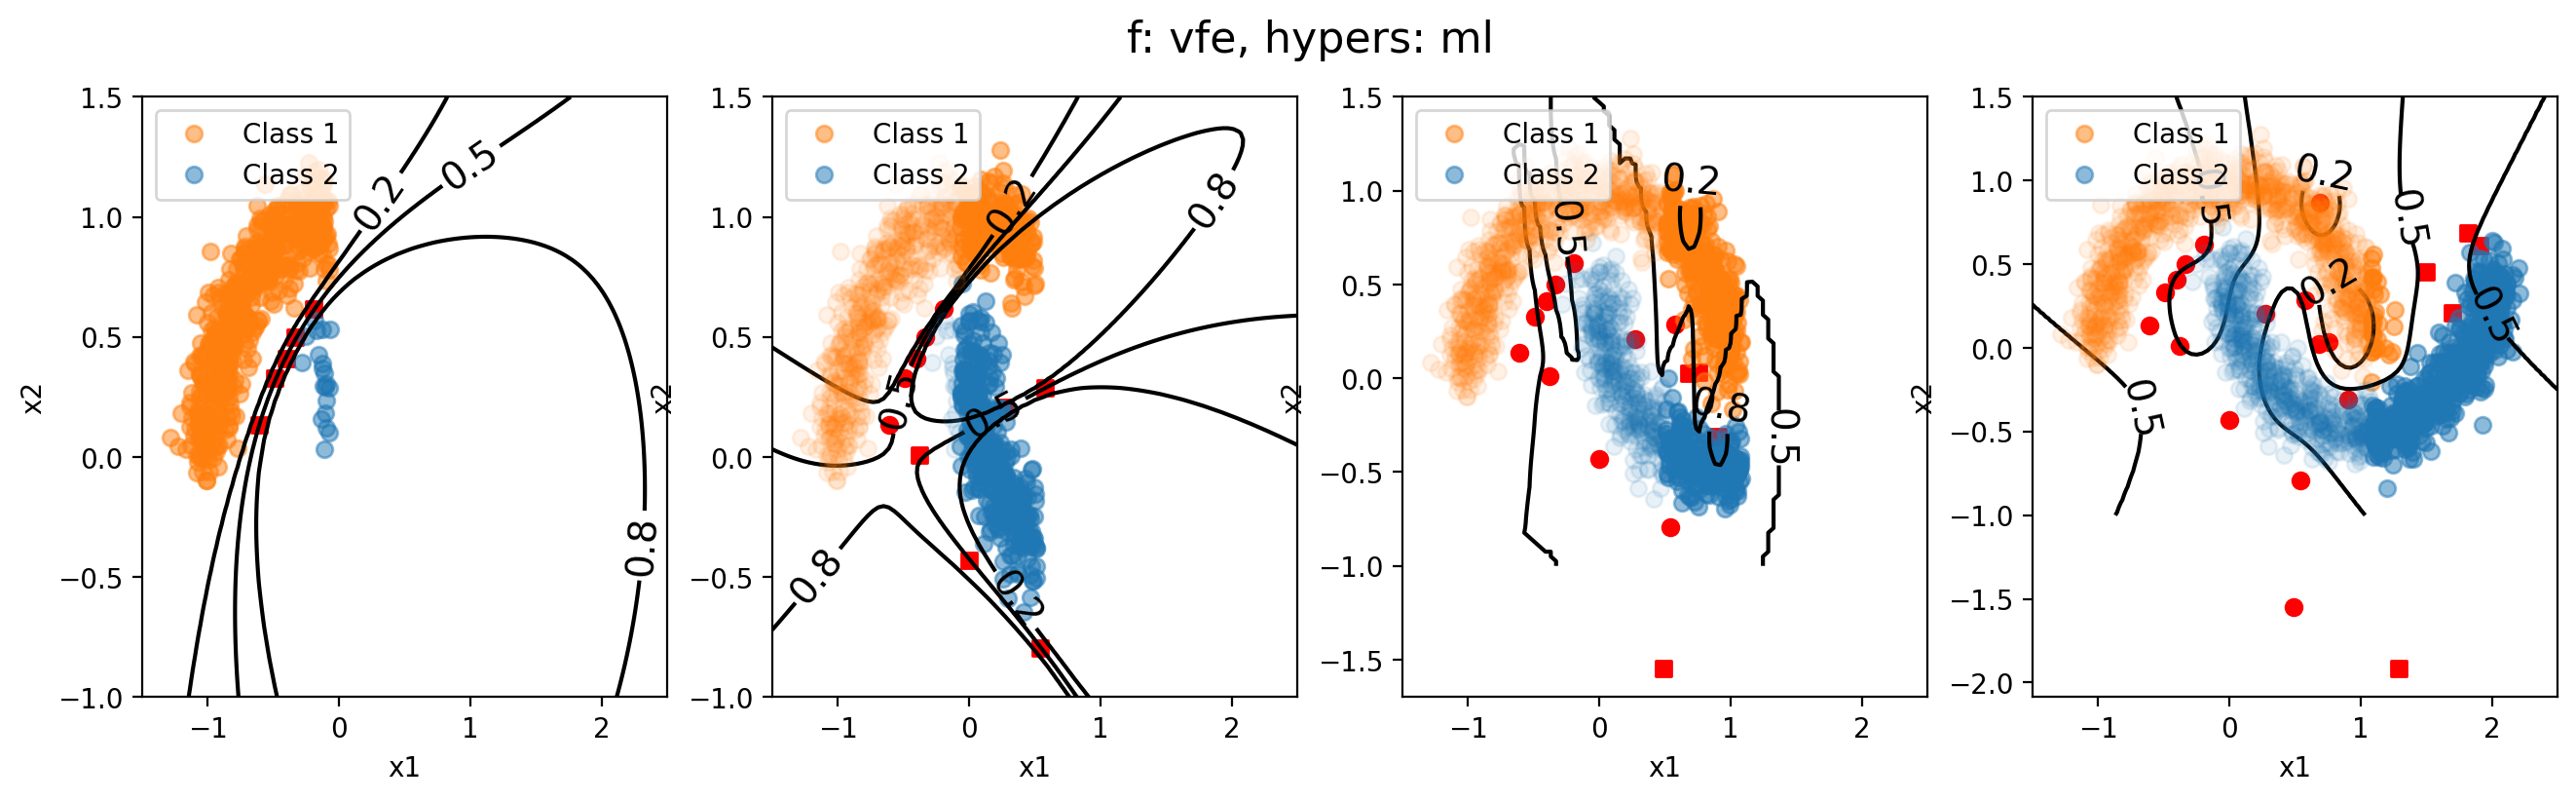

In [44]:
fig, axes = plt.subplots(figsize=(16, 4), nrows=1, ncols=4, dpi=200)

x_old, y_old, z_old = None, None, None

for q, model_state_dict, ax, client in zip(ml_server.log["q"][0:], ml_server.log["model_state_dict"][0:], axes, ml_clients):
    
    x, y = client.data["x"].numpy(), client.data["y"].numpy()
    z = client.inducing_locations.numpy()
    model = copy.deepcopy(ml_server.model)
    model.load_state_dict(model_state_dict)
    
    plot_predictive_distribution(x, y, z, model, q=q, ax=ax, x_old=x_old, y_old=y_old, z_old=z_old)
    
    if x_old is not None:
        x_old = np.concatenate((x_old, x), axis=0)
        y_old = np.concatenate((y_old, y), axis=0)
        z_old = np.concatenate((z_old, z), axis=0)
    else:
        x_old, y_old, z_old = x, y, z
    
plt.suptitle("f: vfe, hypers: ml", fontsize=16)
plt.show()

# Bayesian treatment of hyperparameters

Old approximate posterior: $$q_{old}(f, \theta) = p(f_{\setminus \mathbf{a}} | \mathbf{a}, \theta) q(\mathbf{a}) q_{old}(\theta).$$
New approximate posterior: $$q_{new}(f, \theta) = p(f_{\setminus \mathbf{a}, \mathbf{b}} | \mathbf{a}, \mathbf{b}, \theta) q(\mathbf{a}) q(\mathbf{b} | \mathbf{a}) q_{new}(\theta).$$

The variational objective is given by
$$\mathcal{F}(q_{new}(f, \theta)) = \mathrm{KL}\left[q_{\mathrm{new}}(\theta) \| q_{\mathrm{old}}(\theta)\right]+\int \mathrm{d} \theta q(\theta)(\mathrm{KL}[q(\mathbf{a}, \mathbf{b}) \| p(\mathbf{a}, \mathbf{b} \mid \theta)]) -\int \mathrm{d} \theta q(\theta)(\mathrm{KL}[q(\mathbf{a}) \| p(\mathbf{a} \mid \theta)])-\int \mathrm{d} f \mathrm{~d} \theta q_{\text {new }}(f, \theta) \log p\left(\mathbf{y}_{\text {new }} \mid f, \theta\right).$$

In [45]:
prior_log_lengthscale_std_params = {
    "loc": torch.zeros(D),
    "scale": torch.ones(D) * .5,
}

prior_log_outputscale_std_params = {
    "loc": torch.tensor(1.),
    "scale": torch.tensor(1.),
}

In [46]:
#Why is the train_hypers false? set to true
model_config = {
    "D": D,
    "num_inducing": num_inducing,
    "kernel_class": lambda **kwargs: RBFKernel(**kwargs),
    "kernel_params": {
        "ard_num_dims": D, 
        "train_hypers": True
    },
    "num_predictive_samples": 100
}

model_hyperparameters = {
    "outputscale": 1.,
    "lengthscale": torch.ones(D) * 1.,
}

client_config = {
    "optimiser": "Adam",
    "optimiser_params": {"lr": 1e-2},
    "epochs": 1000,
    "batch_size": len(clients_data[0]["x"]),
    "num_elbo_samples": 10,
    "num_elbo_hyper_samples": 1,
    "num_predictive_samples": 100,
    "train_model": True,
}

bayes_clients = []

# Construct clients.
for i in range(M):
    model_i = SparseGaussianProcessClassification(config=model_config, hyperparameters=model_hyperparameters)
    data_i = clients_data[i]

    # Convert to torch.tensor.
    for k, v in data_i.items():
        #Previously: data_i[k] = torch.tensor(v)
        data_i[k] = v.clone().detach()

        
    # Randomly initialise private inducing points.
    perm = torch.randperm(len(data_i["x"]))
    idx = perm[:model_config["num_inducing"]]
    #Previously: z_i = torch.tensor(data_i["x"][idx]).clone()
    z_i = data_i["x"][idx].clone().detach()
    
    bayes_clients.append(ContinualLearningSGPClientBayesianHypers(
        data=data_i, model=model_i, inducing_locations=z_i, config=client_config))

model = SparseGaussianProcessClassification(config=model_config)

q = MultivariateGaussianDistributionWithZ(
    inducing_locations=None,
    #previously None
    nat_params=init_nat_params, 
    is_trainable=False
)

qeps = HyperparameterDistribution(
    {
        "lengthscale": LogNormalDistribution(std_params=prior_log_lengthscale_std_params, is_trainable=True),
        "outputscale": LogNormalDistribution(std_params=prior_log_outputscale_std_params, is_trainable=True)
    }
)

bayesian_server = ContinualLearningServerBayesianHypers(
    model=model, 
    p=q, 
    peps=qeps,
    clients=bayes_clients,
    config=server_config
)

{'ard_num_dims': 2, 'train_hypers': True}
{'ard_num_dims': 2, 'train_hypers': True}
{'ard_num_dims': 2, 'train_hypers': True}
{'ard_num_dims': 2, 'train_hypers': True}
{'ard_num_dims': 2, 'train_hypers': True}


In [47]:
while not bayesian_server.should_stop():
    bayesian_server.tick()

    # Obtain predictions.
    dists = bayesian_server.model_predict(torch.tensor(test_set["x"]), diag=True)

    preds = []
    for pp in dists:
        preds.append(pp.mean.detach().numpy())

    preds = np.array(preds).mean(0)
    test_acc = np.sum(
        np.abs(2 * (preds > 0.5) - 1 + test_set["y"]) > 0) / np.size(test_set["y"])
    

    print(test_acc)

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9523809523809523


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9866666666666667


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9904761904761905


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9904761904761905


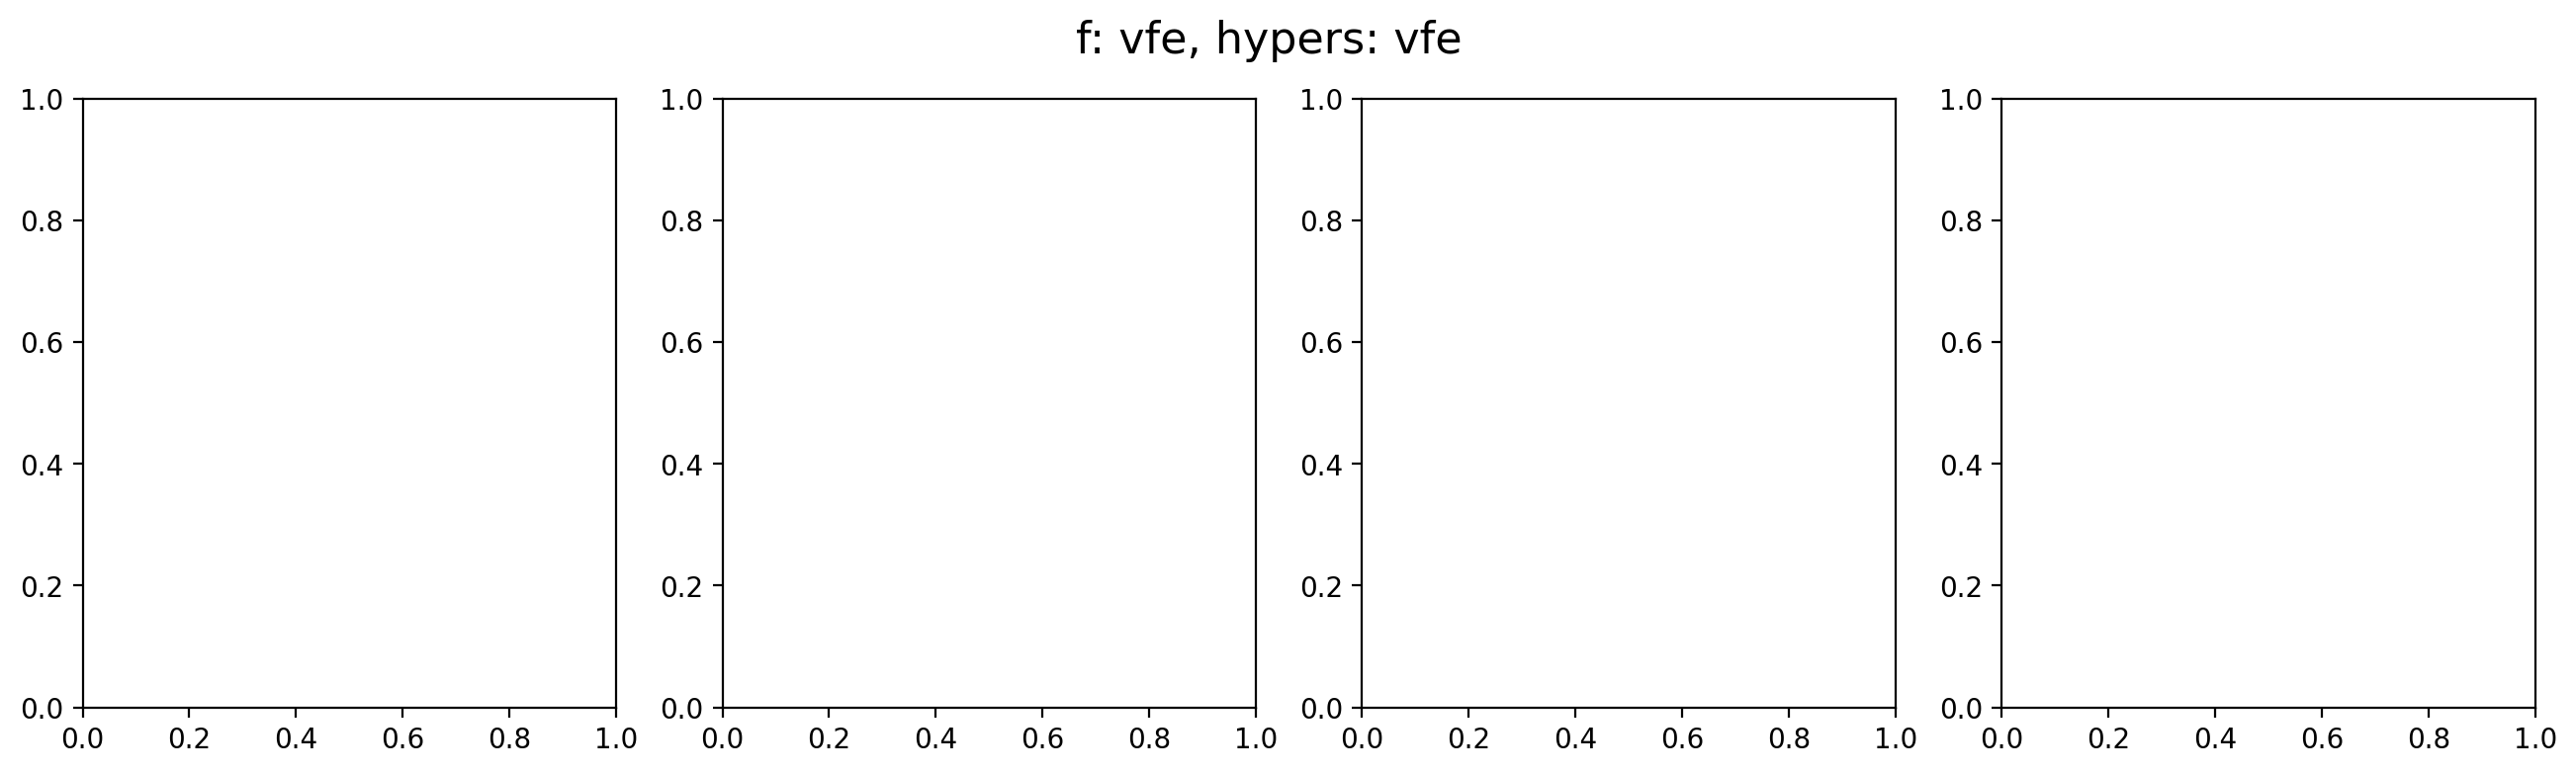

In [53]:
x, y = training_set["x"][::5], training_set["y"][::5]

fig, axes = plt.subplots(figsize=(16, 4), nrows=1, ncols=4, dpi=200)

x_old, y_old, z_old = None, None, None
for q, qeps, ax, client in zip(bayesian_server.log["q"][0:], bayesian_server.log["qeps"][0:], axes, bayesian_server.clients):
    x, y = client.data["x"].numpy(), client.data["y"].numpy()
    z = client.inducing_locations.numpy()
    model = copy.deepcopy(bayesian_server.model)
    model.load_state_dict(model_state_dict)
    
    plot_bayesian_predictive_distribution(x, y, z, model, q=q, qeps=qeps, ax=ax, x_old=x_old, y_old=y_old, z_old=z_old)
    
    if x_old is not None:
        x_old = np.concatenate((x_old, x), axis=0)
        y_old = np.concatenate((y_old, y), axis=0)
        z_old = np.concatenate((z_old, z), axis=0)
    else:
        x_old, y_old, z_old = x, y, z
    
plt.suptitle("f: vfe, hypers: vfe", fontsize=16)
plt.show()

# Visualise hyperparameter distributions

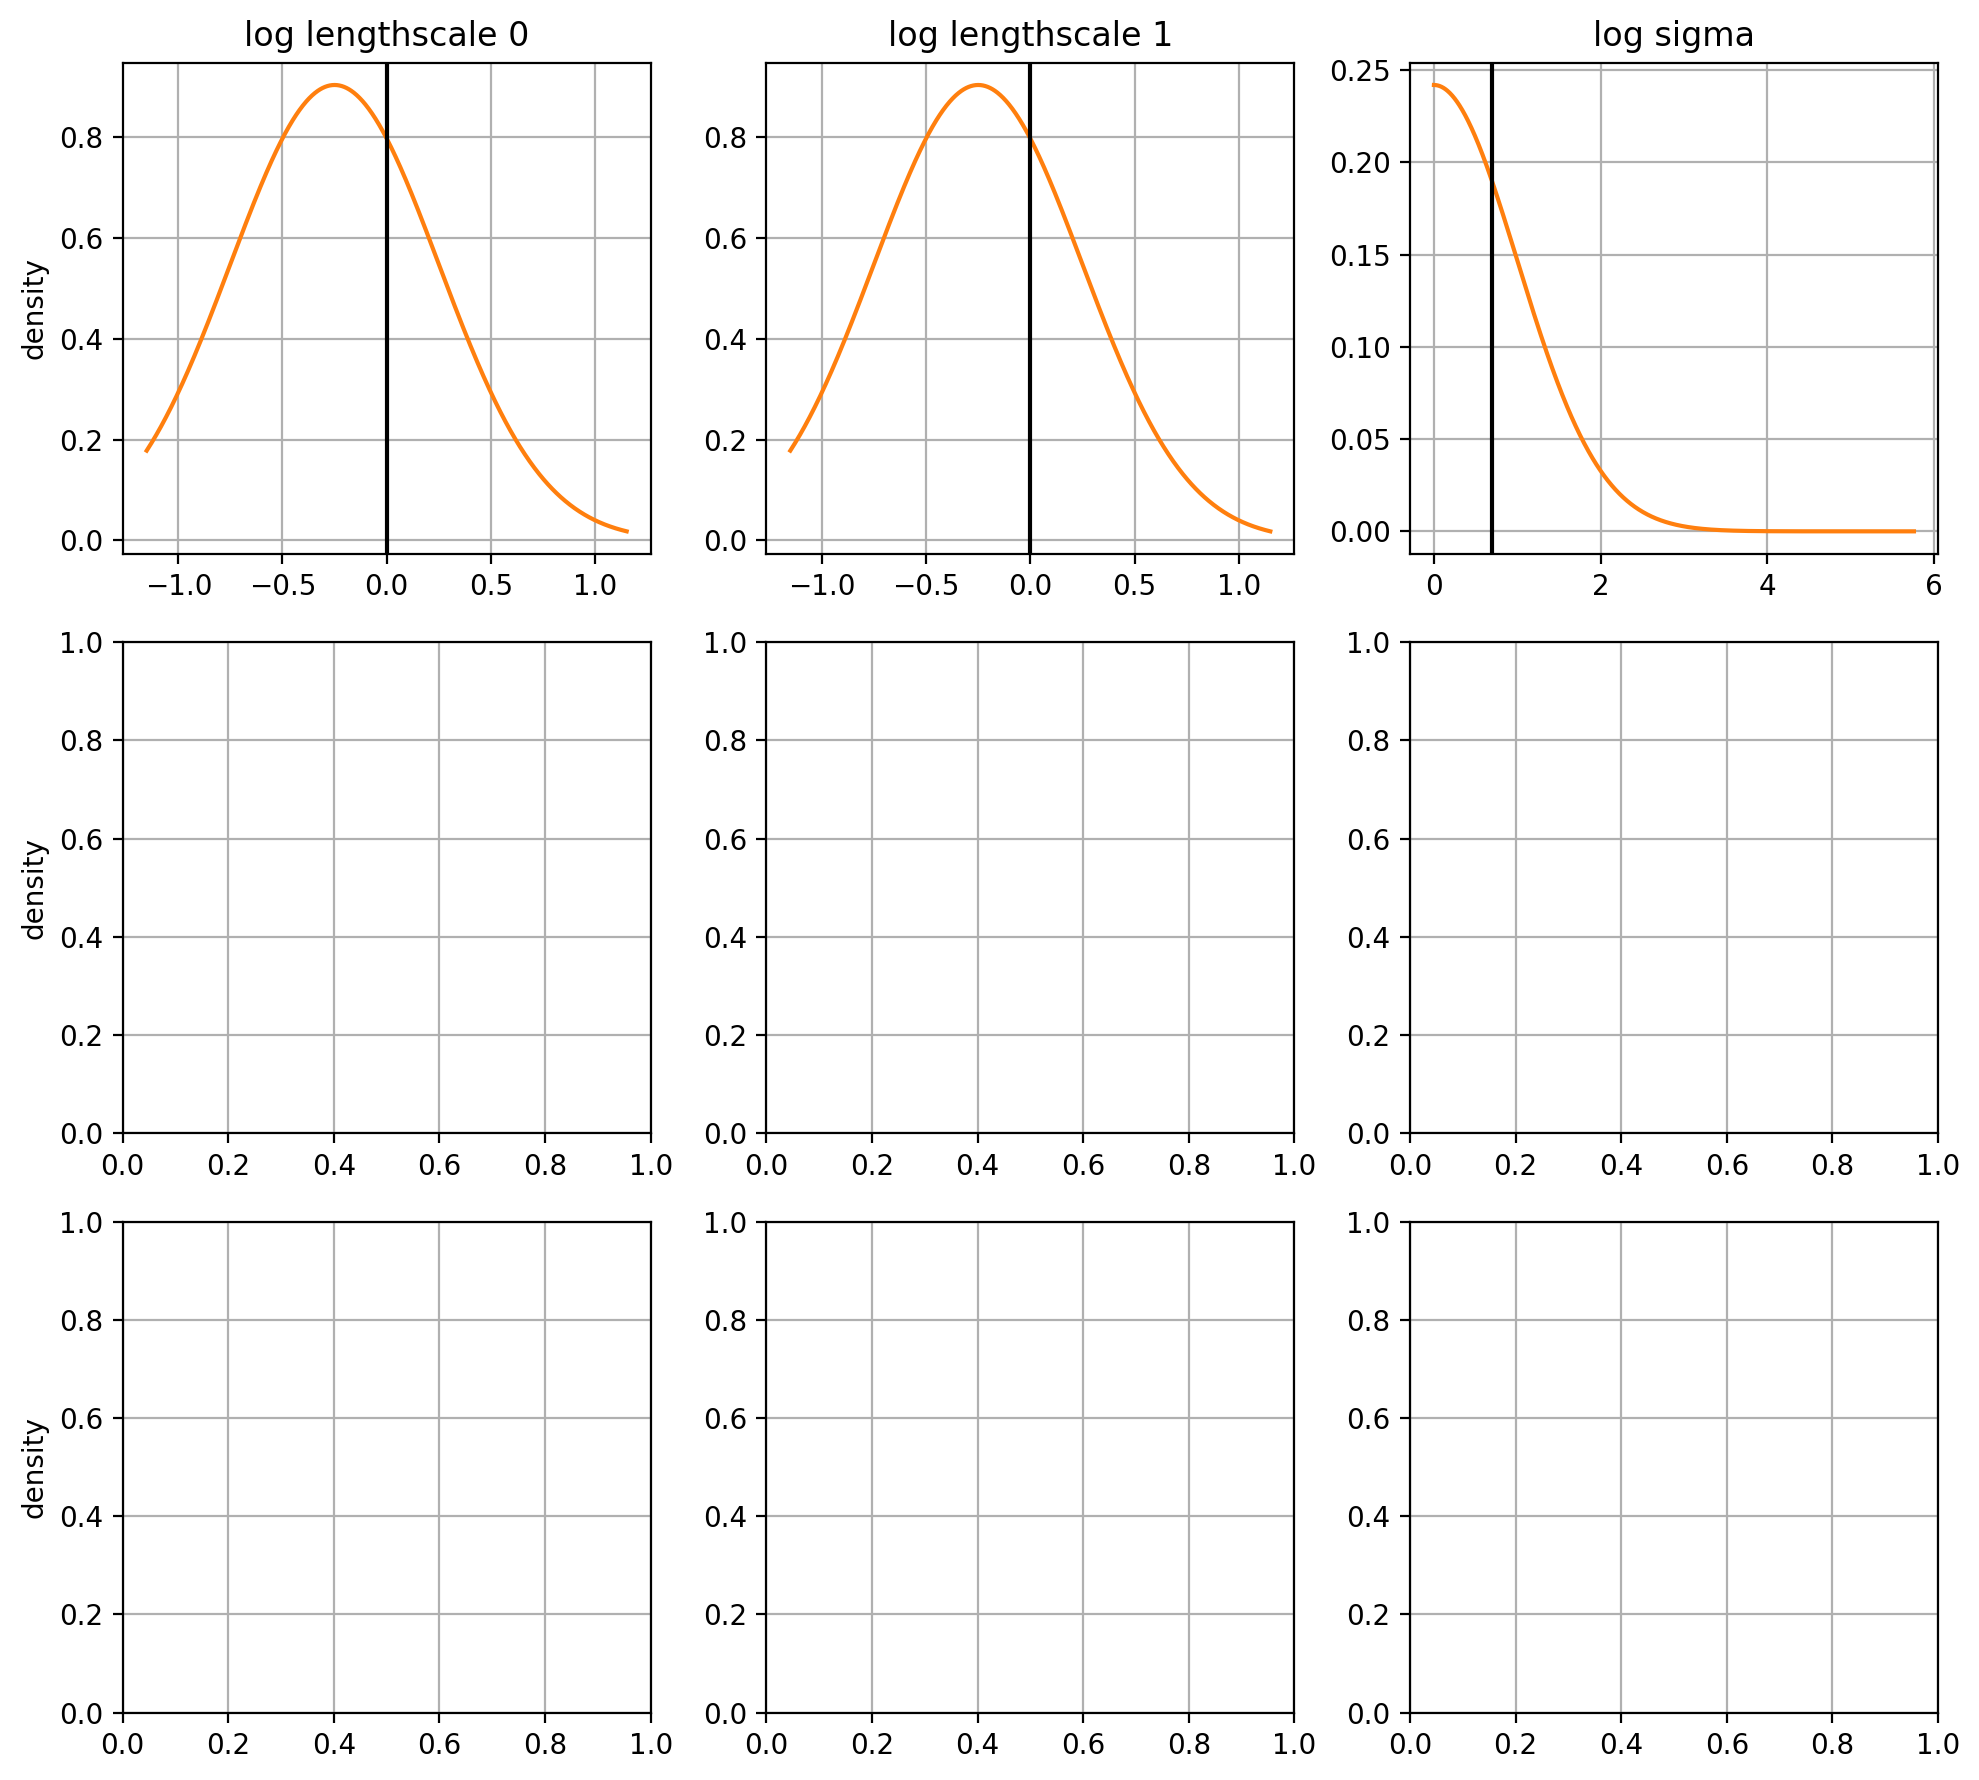

In [52]:
fig, axes = plt.subplots(figsize=(10, 9), nrows=3, ncols=3, dpi=200)
i=0
for ml_model_state_dict, qeps, row in zip(ml_server.log["model_state_dict"][0:], bayesian_server.log["qeps"][0:], axes):

    ml_model = copy.deepcopy(ml_server.model)
    ml_model.load_state_dict(ml_model_state_dict)
        
    lx1 = torch.logspace(-.5, .5, 1000).unsqueeze(-1)
    lx2 = torch.logspace(-.5, .5, 1000).unsqueeze(-1)
    lx = torch.cat((lx1, lx2), dim=1)
    osx = torch.logspace(0, 2.5, 1000)

    q_l = qeps.distributions["lengthscale"].distribution
    q_os = qeps.distributions["outputscale"].distribution
    
    q_l_probs = q_l.log_prob(lx).exp()
    q_os_probs = q_os.log_prob(osx).exp()

    row[0].plot(lx1.log(), q_l_probs[:, 0], c="C1", alpha=1.)
    
    row[0].axvline(ml_model.kernel.lengthscale[0][0].log().item(), c="k")
    
    row[1].plot(lx2.log(), q_l_probs[:, 1], c="C1", alpha=1., label="Dataset {}".format(i))
    row[1].axvline(ml_model.kernel.lengthscale[0][1].log().item(), c="k")

    row[2].plot(osx.log(), q_os_probs, c="C1", alpha=1.)
    row[2].axvline(ml_model.kernel.outputscale.log().item(), c="k")
    
axes[0, 0].set_title("log lengthscale 0")
axes[0, 1].set_title("log lengthscale 1")
axes[0, 2].set_title("log sigma")
axes[0, 0].set_ylabel("density")
axes[1, 0].set_ylabel("density")
axes[2, 0].set_ylabel("density")

for ax in axes.flatten():
    ax.grid(visible=True)
    
plt.tight_layout()
plt.show()